In [1]:
import threading
import torch
import random
import os
import scanpy as sc
import pandas as pd
import numpy as np
import scipy

max_connections = 5 # 定义最大线程数
pool_sema = threading.Semaphore(max_connections) # 使用Semaphore方法
pool_sema.acquire() # 加锁，限制线程数


#os.environ["CUDA_VISIBLE_DEVICES"] = '2'
torch.cuda.set_device(1)
device = torch.device("cuda:1")


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
setup_seed(42)

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy

merfish_raw = pd.read_csv('/data/msyuan/Datasets/Multi-Omics-Datasets/uniportdata-MERFISH/Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv')
index_1 = merfish_raw["Animal_ID"] == 1
merfish_1 = merfish_raw[index_1]
index_2 = merfish_raw["Cell_class"] != 'Ambiguous'
merfish_2 = merfish_1[index_2]
cols = merfish_raw.columns[9:]
merfish_matrix = merfish_2[cols]
merfish_matrix = merfish_matrix[merfish_matrix.columns[np.sum(merfish_matrix, axis=0)!=0]]
merfish_coor = merfish_2[['Centroid_X', 'Centroid_Y']]
celltype_merfish = merfish_2[['Cell_class']]
celltype_merfish = np.array(merfish_2[['Cell_class']]).flatten()
for i in range(len(celltype_merfish)):
    tmp = celltype_merfish[i].split(' ')
    if tmp[0] == 'OD':
        celltype_merfish[i] = ''.join([tmp[0],' ',tmp[1]])
    else:
        celltype_merfish[i] = tmp[0]
#print(np.unique(celltype_merfish))

file_path = '/data/msyuan/Datasets/Multi-Omics-Datasets/uniportdata-MERFISH'
#labels_merfish = pd.read_csv(file_path + '/MERFISH_mouse1_cluster.txt', sep='\t')
#celltype_merfish = labels_merfish['cluster_main'].values
labels_rna = pd.read_csv(file_path + '/scRNA_cluster.txt', sep='\t')
celltype_rna = labels_rna['cluster_main'].values
adata_merfish = sc.AnnData(merfish_matrix)
adata_merfish.X = scipy.sparse.csr_matrix(adata_merfish.X)
adata_rna = sc.read_h5ad(file_path + '/rna0.h5ad')

adata_merfish.obs['cell_type'] = celltype_merfish
adata_merfish.obs['domain_id'] = 0
adata_merfish.obs['domain_id'] = adata_merfish.obs['domain_id'].astype('category')
adata_merfish.obs['source'] = 'MERFISH'
print("adata_merfish:",adata_merfish, np.unique(adata_merfish.obs['cell_type']))

adata_rna.obs['cell_type'] = celltype_rna
adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')
adata_rna.obs['source'] = 'RNA'
print("adata_rna:",adata_rna, np.unique(adata_rna.obs['cell_type']))

# adata_merfish, adata_rna. merfish_coor(merfish数据空间坐标)

/data/msyuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/data/msyuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/data/msyuan/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


adata_merfish: AnnData object with n_obs × n_vars = 64373 × 160
    obs: 'cell_type', 'domain_id', 'source' ['Astrocyte' 'Endothelial' 'Ependymal' 'Excitatory' 'Inhibitory'
 'Microglia' 'OD Immature' 'OD Mature' 'Pericytes']
adata_rna: AnnData object with n_obs × n_vars = 30370 × 21043
    obs: 'cell_type', 'domain_id', 'source' ['Astrocyte' 'Endothelial' 'Ependymal' 'Excitatory' 'Fibroblast'
 'Inhibitory' 'Macrophage' 'Microglia' 'Mural' 'Newly formed OD'
 'OD Immature' 'OD Mature']


In [3]:
# 敲掉rna数据集里的Microglia（merfish里特别少的一类）
merfish_index = list(np.where(adata_merfish.obs["cell_type"] == 'Pericytes')[0])
left_index = []
for i in range(len(adata_merfish)):
    if i not in merfish_index:
        left_index.append(i)
adata_merfish = adata_merfish[left_index,:]

adata_cm = adata_merfish.concatenate(adata_rna, join='inner', batch_key='domain_id')
print(adata_cm.obs)

# construct labels
labels = np.zeros(len(adata_cm))
cell_types = np.unique(adata_cm.obs["cell_type"])
type_nums = np.arange(len(adata_cm))
adata_cm.obs["label"] = adata_cm.obs["cell_type"]
for i in range(len(cell_types)):
    labels[adata_cm.obs["label"]==cell_types[i]] = type_nums[i]
labels = np.asarray(labels, dtype=int)
adata_cm.obs["labels"] = labels
rna_labels = labels[adata_cm.obs["domain_id"]=='1']
merfish_labels = labels[adata_cm.obs["domain_id"]=='0']

/data/msyuan/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


                       cell_type domain_id   source
0-0                    Astrocyte         0  MERFISH
1-0                   Inhibitory         0  MERFISH
2-0                   Inhibitory         0  MERFISH
3-0                   Inhibitory         0  MERFISH
4-0                   Inhibitory         0  MERFISH
...                          ...       ...      ...
TTTGGTTGTTATCACG-6-1  Inhibitory         1      RNA
TTTGGTTGTTATTCTC-6-1  Inhibitory         1      RNA
TTTGTCAGTTCCGTCT-6-1  Inhibitory         1      RNA
TTTGTCATCGTGGGAA-6-1  Inhibitory         1      RNA
TTTGTCATCTTTACAC-6-1  Excitatory         1      RNA

[94105 rows x 3 columns]


In [4]:
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler


def batch_scale(adata, use_rep='X', chunk_size=20000):
    """
    Batch-specific scale data

    Parameters
    ----------
    adata
        AnnData
    use_rep
        use '.X' or '.obsm'
    chunk_size
        chunk large data into small chunks

    """
    for b in adata.obs['source'].unique():
        idx = np.where(adata.obs['source'] == b)[0]
        if use_rep == 'X':
            scaler = MaxAbsScaler(copy=False).fit(adata.X[idx])
            for i in range(len(idx) // chunk_size + 1):
                adata.X[idx[i * chunk_size:(i + 1) * chunk_size]] = scaler.transform(
                    adata.X[idx[i * chunk_size:(i + 1) * chunk_size]])
        else:
            scaler = MaxAbsScaler(copy=False).fit(adata.obsm[use_rep][idx])
            for i in range(len(idx) // chunk_size + 1):
                adata.obsm[use_rep][idx[i * chunk_size:(i + 1) * chunk_size]] = scaler.transform(
                    adata.obsm[use_rep][idx[i * chunk_size:(i + 1) * chunk_size]])


sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, batch_key='domain_id', inplace=False, subset=True)
batch_scale(adata_cm)

sc.pp.normalize_total(adata_merfish)
sc.pp.log1p(adata_merfish)
sc.pp.highly_variable_genes(adata_merfish, n_top_genes=2000, inplace=False, subset=True)
batch_scale(adata_merfish)

sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
batch_scale(adata_rna)

/data/msyuan/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/data/msyuan/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
# network structure
import math
import torch
from torch import nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.nn.parameter import Parameter
from torch.nn import init
from torch.autograd import Function

activation = {
    'relu': nn.ReLU(),
    'rrelu': nn.RReLU(),
    'sigmoid': nn.Sigmoid(),
    'leaky_relu': nn.LeakyReLU(),
    'tanh': nn.Tanh(),
    '': None
}


class DSBatchNorm(nn.Module):
    """
    Domain-specific Batch Normalization
    """

    def __init__(self, num_features, n_domain, eps=1e-5, momentum=0.1):
        """
        Parameters
        ----------
        num_features
            dimension of the features
        n_domain
            domain number
        """
        super().__init__()
        self.n_domain = n_domain
        self.num_features = num_features
        self.bns = nn.ModuleList([nn.BatchNorm1d(num_features, eps=eps, momentum=momentum) for i in range(n_domain)])

    def reset_running_stats(self):
        for bn in self.bns:
            bn.reset_running_stats()

    def reset_parameters(self):
        for bn in self.bns:
            bn.reset_parameters()

    def _check_input_dim(self, input):
        raise NotImplementedError

    def forward(self, x, y):
        out = torch.zeros(x.size(0), self.num_features, device=x.device)  # , requires_grad=False)
        for i in range(self.n_domain):
            indices = np.where(y.cpu().numpy() == i)[0]

            if len(indices) > 1:
                out[indices] = self.bns[i](x[indices])
            elif len(indices) == 1:
                # out[indices] = x[indices]
                self.bns[i].training = False
                out[indices] = self.bns[i](x[indices])
                self.bns[i].training = True
        return out


class Block(nn.Module):
    """
    Basic block consist of:
        fc -> bn -> act -> dropout
    """

    def __init__(
            self,
            input_dim,
            output_dim,
            norm='',
            act='',
            dropout=0
    ):
        """
        Parameters
        ----------
        input_dim
            dimension of input
        output_dim
            dimension of output
        norm
            batch normalization,
                * '' represent no batch normalization
                * 1 represent regular batch normalization
                * int>1 represent domain-specific batch normalization of n domain
        act
            activation function,
                * relu -> nn.ReLU
                * rrelu -> nn.RReLU
                * sigmoid -> nn.Sigmoid()
                * leaky_relu -> nn.LeakyReLU()
                * tanh -> nn.Tanh()
                * '' -> None
        dropout
            dropout rate
        """
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

        if type(norm) == int:
            if norm == 1:  # TO DO
                self.norm = nn.BatchNorm1d(output_dim)
            else:
                self.norm = DSBatchNorm(output_dim, norm)
        else:
            self.norm = None

        self.act = activation[act]

        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = None

    def forward(self, x, y=None):
        h = self.fc(x)
        if self.norm:
            if len(x) == 1:
                pass
            elif self.norm.__class__.__name__ == 'DSBatchNorm':
                h = self.norm(h, y)
            else:
                h = self.norm(h)
        if self.act:
            h = self.act(h)
        if self.dropout:
            h = self.dropout(h)
        return h


class NN(nn.Module):
    """
    Neural network consist of multi Blocks
    """

    def __init__(self, input_dim, cfg):
        """
        Parameters
        ----------
        input_dim
            input dimension
        cfg
            model structure configuration, 'fc' -> fully connected layer

        Example
        -------
        >>> latent_dim = 10
        >>> dec_cfg = [['fc', x_dim, n_domain, 'sigmoid']]
        >>> decoder = NN(latent_dim, dec_cfg)
        """
        super().__init__()
        net = []
        for i, layer in enumerate(cfg):
            if i == 0:
                d_in = input_dim
            if layer[0] == 'fc':
                net.append(Block(d_in, *layer[1:]))
            d_in = layer[1]
        self.net = nn.ModuleList(net)

    def forward(self, x, y=None):
        for layer in self.net:
            x = layer(x, y)
        return x


class Encoder(nn.Module):
    """
    VAE Encoder
    """

    def __init__(self, input_dim, cfg):
        """
        Parameters
        ----------
        input_dim
            input dimension
        cfg
            encoder configuration, e.g. enc_cfg = [['fc', 1024, 1, 'relu'],['fc', 10, '', '']]
        """
        super().__init__()

        enc = []
        mu_enc = []
        var_enc = []

        h_dim = cfg[-2][1]

        enc.append(NN(input_dim[0], cfg[:-1]))
        mu_enc.append(NN(h_dim, cfg[-1:]))
        var_enc.append(NN(h_dim, cfg[-1:]))

        self.enc = nn.ModuleList(enc)
        self.mu_enc = nn.ModuleList(mu_enc)
        self.var_enc = nn.ModuleList(var_enc)

    def reparameterize(self, mu, var):
        return Normal(mu, var.sqrt()).rsample()

    def forward(self, x, domain, y=None):
        """
        """
        q = self.enc[domain](x, y)
        mu = self.mu_enc[domain](q, y)
        var = torch.exp(self.var_enc[domain](q, y))
        z = self.reparameterize(mu, var)
        return z, mu, var


class Decoder(nn.Module):
    """
    VAE Decoder
    """

    def __init__(self, z_dim, cfg):
        """
        Parameters
        ----------
        z_dim
            latent dimension
        cfg
            decoder configuration, e.g. dec_cfg = [['fc', adatas[i].obsm[obsm[i]].shape[1], 1, 'sigmoid']]
        """
        super().__init__()

        dec = []
        for i in cfg.keys():
            dec.append(NN(z_dim, cfg[i]))

        self.dec = nn.ModuleList(dec)

    def forward(self, z, domain, y=None):
        """
        """
        reconx_x = self.dec[domain](z, y)

        return reconx_x


class ProtoCLS(nn.Module):
    """
    prototype-based classifier
    L2-norm + a fc layer (without bias)
    """

    def __init__(self, in_dim, out_dim, temp=0.05):
        super(ProtoCLS, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.tmp = temp
        self.weight_norm()

    def forward(self, x):
        x = F.normalize(x)
        x = self.fc(x) / self.tmp
        return x

    def weight_norm(self):
        w = self.fc.weight.data
        norm = w.norm(p=2, dim=1, keepdim=True)
        self.fc.weight.data = w.div(norm.expand_as(w))


class CLS(nn.Module):
    """
    a classifier made up of projection head and prototype-based classifier
    """

    def __init__(self, in_dim, out_dim, hidden_mlp=1024, feat_dim=16, temp=0.05):
        super(CLS, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(in_dim, hidden_mlp),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_mlp, feat_dim))
        self.ProtoCLS = ProtoCLS(feat_dim, out_dim, temp)

    def forward(self, x):
        before_lincls_feat = self.projection_head(x)
        after_lincls = self.ProtoCLS(before_lincls_feat)
        return before_lincls_feat, after_lincls

In [6]:
import ot
# author: Musu Yuan
# modified from UniOT for UniDA(NIPS2022)

def ubot_CCD(sim, beta, stopThr=1e-4):
    # fake_size (Adaptive filling) + fill_size (memory queue filling) + mini-batch size
    M = -sim
    alpha = ot.unif(sim.size(0))
    Q_st = ot.unbalanced.sinkhorn_knopp_unbalanced(alpha, beta, M.detach().cpu().numpy(),
                                                   reg=0.01, reg_m=0.5, stopThr=stopThr)
    Q_st = torch.from_numpy(Q_st).float().cuda()

    # make sum equals to 1
    sum_pi = torch.sum(Q_st)
    Q_st_bar = Q_st / sum_pi
    # confidence score w^t_i
    wt_i, pseudo_label = torch.max(Q_st_bar, 1)

    new_beta = torch.sum(Q_st_bar, 0).cpu().numpy()

    return pseudo_label, new_beta, Q_st_bar, wt_i

In [7]:
class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.
    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.
    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """

    def __init__(self, num_classes, epsilon=0.1, use_gpu=True, reduction=True):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.use_gpu = use_gpu
        self.reduction = reduction
        self.logsoftmax = nn.LogSoftmax(dim=1)  # 对每一行的所有元素进行softmax运算，并使得每一行所有元素和为1，再取log.

    def forward(self, inputs, targets):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (num_classes)
        """
        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).cpu(), 1)  #

        if self.use_gpu: targets = targets.cuda()
        targets = (1 -
                   self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (-targets * log_probs).sum(dim=1)  # 对行求和，消掉列，keepdim=True则列变成1
        if self.reduction:
            return loss.mean()
        else:
            return loss
        return loss

In [8]:
#### OT Loss
#!/usr/bin/env 
"""
# Author: Kai Cao
# Modified from RAE
"""
from torch.distributions import Normal, kl_divergence

def kl_div(mu, var, weight=None):
    loss = kl_divergence(Normal(mu, var.sqrt()), Normal(torch.zeros_like(mu),torch.ones_like(var))).sum(dim=1)
    
    # if weight is not None:
    #     loss = loss * weight.squeeze(dim=1)
    return loss.mean()
 
# def balanced_binary_cross_entropy(recon_x, x):

#     return -torch.sum(x * torch.log(recon_x + 1e-8) + (1 - x) * torch.log(1 - recon_x + 1e-8), dim=-1)

def distance_matrix(pts_src: torch.Tensor, pts_dst: torch.Tensor, p: int = 2):
    """
    Returns the matrix of ||x_i-y_j||_p^p.

    """
    x_col = pts_src.unsqueeze(1)
    y_row = pts_dst.unsqueeze(0)
    distance = torch.sum((torch.abs(x_col - y_row)) ** p, 2)
    return distance

def distance_gmm(mu_src: torch.Tensor, mu_dst: torch.Tensor, var_src: torch.Tensor, var_dst: torch.Tensor):
    """
    Calculate a Wasserstein distance matrix between the gmm distributions with diagonal variances
    
    """
    std_src = var_src.sqrt()
    std_dst = var_dst.sqrt()
    distance_mean = distance_matrix(mu_src, mu_dst, p=2)
    distance_var = distance_matrix(std_src, std_dst, p=2)

    # distance_var = torch.sum(sum_matrix(std_src, std_dst) - 2 * (prod_matrix(std_src, std_dst) ** 0.5), 2)
    
    return distance_mean + distance_var

def pdists(A, squared = False, eps = 0):
    prod = torch.mm(A, A.t())
    norm = prod.diag().unsqueeze(1).expand_as(prod)
    res = (norm + norm.t() - 2 * prod).clamp(min = 0)
    
    if squared:
        return res
    else:
        res = res.clamp(min = eps).sqrt()
        return res

In [9]:
adatas = [adata_merfish, adata_rna]
num_cell = []
num_gene = []
for i, adata in enumerate(adatas):
    num_cell.append(adata.X.shape[0])
    num_gene.append(adata.X.shape[1])

n_domain = len(adatas)
enc = [['fc', 1024, 1, 'relu'], ['fc', 16, '', '']]
num_gene.append(adata_cm.X.shape[1])
dec = {}
dec[0] = [['fc', num_gene[n_domain], n_domain, 'sigmoid']]  # common decoder
for i in range(1, n_domain + 1):
    dec[i] = [['fc', num_gene[i - 1], 1, 'sigmoid']]  # dataset-specific decoder

x_dim = {}
for key in dec.keys():
    x_dim[key] = dec[key][-1][1]
    z_dim = enc[-1][1]

source_classes = list(np.unique(adata_rna.obs["cell_type"]))
print("source_classes:", source_classes)
target_classes = list(np.unique(adata_merfish.obs["cell_type"]))
print("target_classes:", target_classes)
target_private_classes = []
for i in range(len(target_classes)):
    if target_classes[i] not in source_classes:
        target_private_classes.append(target_classes[i])
print("target_private_classes:", target_private_classes)

feat_dim = 32

source_classes: ['Astrocyte', 'Endothelial', 'Ependymal', 'Excitatory', 'Fibroblast', 'Inhibitory', 'Macrophage', 'Microglia', 'Mural', 'Newly formed OD', 'OD Immature', 'OD Mature']
target_classes: ['Astrocyte', 'Endothelial', 'Ependymal', 'Excitatory', 'Inhibitory', 'Microglia', 'OD Immature', 'OD Mature']
target_private_classes: []


In [10]:
# dataloader
from collections import Counter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, WeightedRandomSampler


class SingleCellDataset(Dataset):

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.shape = data.shape

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx].toarray().squeeze()
        labels = self.labels[idx].squeeze()

        return x, labels, idx


adata_cm_rna = adata_cm[adata_cm.obs["domain_id"] == '1']
adata_cm_merfish = adata_cm[adata_cm.obs["domain_id"] == '0']
source_cm_ds = SingleCellDataset(adata_cm_rna.X, rna_labels)
target_cm_ds = SingleCellDataset(adata_cm_merfish.X, merfish_labels)
source_sp_ds = SingleCellDataset(adata_rna.X, rna_labels)
target_sp_ds = SingleCellDataset(adata_merfish.X, merfish_labels)

batch_size = 256
num_workers = 4
classes = rna_labels
freq = Counter(classes)
class_weight = {x: 1.0 / freq[x] for x in freq}
source_weights = [class_weight[x] for x in classes]
sampler = WeightedRandomSampler(source_weights, len(source_cm_ds.labels))

source_cm_dl = DataLoader(dataset=source_cm_ds, batch_size=batch_size,
                          sampler=sampler, num_workers=num_workers, drop_last=True)
target_cm_dl = DataLoader(dataset=target_cm_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, drop_last=True)
test_source_cm_dl = DataLoader(dataset=source_cm_ds, batch_size=batch_size,
                               sampler=sampler, num_workers=num_workers, drop_last=False)
test_target_cm_dl = DataLoader(dataset=target_cm_ds, batch_size=batch_size, shuffle=True,
                               num_workers=num_workers, drop_last=False)
# output: x, domain_id, idx

In [11]:
merfish_coor

,Centroid_X,Centroid_Y
0,-3211.562145,2608.541476
1,-3207.923151,2621.795437
2,-3209.578004,2633.153494
3,-3203.853515,2756.045983
4,-3202.682705,2608.803635
...,...,...
73649,2220.422637,-2538.615415
73650,2136.112688,-2725.771187
73652,2164.034469,-2531.472820
73653,2238.056389,-2354.211194


In [12]:
import torch.nn.functional as F
from torch.distributions import Beta
from torch.distributions import Normal, kl_divergence
from easydl import AccuracyCounter, one_hot, variable_to_numpy, clear_output

torch.cuda.current_device()
torch.cuda._initialized = True
class_num = len(source_classes)
lambda_recon = 2000
lambda_kl = 0.5
lambda_spa = 0.01
lambda_cd = 0.1
lambda_nb = 1.0

beta = None
beta_s = ot.unif(class_num)
mu = 0.6
gamma = 0.6
temp = 0.1
k = 10

maxiter = 20000
miditer1 = 3000
miditer2 = 6000
miditer3 = 3000
iteration = 0
test_freq = 1000


# nueral networks
encoder = Encoder(x_dim, enc).cuda()
decoder = Decoder(z_dim, dec).cuda()
classifier = CLS(z_dim, len(source_classes)).cuda()

optim_enc = torch.optim.Adam(encoder.parameters(), lr=2e-4, weight_decay=5e-4)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=2e-4, weight_decay=5e-4)
optim_cls = torch.optim.Adam(classifier.parameters(), lr=2e-4, weight_decay=5e-4)

target_coor = torch.tensor(np.array(merfish_coor)).cuda()
target_coor = torch.tensor(target_coor, dtype=torch.float)
target_coor = target_coor/torch.max(target_coor, axis=0)[0]

while iteration < maxiter:
    iters = zip(source_cm_dl, target_cm_dl)
    for minibatch_id, ((im_source, label_source, id_source), (im_target, label_target, id_target)) in enumerate(iters):

        label_source = label_source.cuda()
        label_target = label_target.cuda()
        im_source = im_source.cuda()
        im_target = im_target.cuda()
        xs_source = torch.tensor(source_sp_ds[id_source.numpy()][0]).cuda()
        xs_target = torch.tensor(target_sp_ds[id_target.numpy()][0]).cuda()
        y_source = torch.ones(len(im_source)).long().cuda()
        y_target = torch.zeros(len(im_target)).long().cuda()
        batch_coor = target_coor[id_target]

        z_source, mu_source, var_source = encoder(im_source, 0, y_source)
        z_target, mu_target, var_target = encoder(im_target, 0, y_target)

        recon_source_c = decoder.dec[0](z_source, y_source)
        recon_target_c = decoder.dec[0](z_target, y_target)
        recon_source_s = decoder.dec[2](z_source, y_source)
        recon_target_s = decoder.dec[1](z_target, y_target)

        before_lincls_feat_s, after_lincls_s = classifier(z_source)
        before_lincls_feat_t, after_lincls_t = classifier(z_target)

        norm_feat_s = F.normalize(before_lincls_feat_s)
        norm_feat_t = F.normalize(before_lincls_feat_t)

        # reconstruction loss
        recon_crit = nn.BCELoss()
        recon_loss = torch.tensor(0.0).cuda()

        recon_loss += recon_crit(recon_source_c, im_source) + recon_crit(recon_target_c, im_target)
        recon_loss += 0.5 * (recon_crit(recon_source_s, xs_source) + recon_crit(recon_target_s, xs_target))
        kl_loss = torch.tensor(0.0).cuda()
        kl_loss += kl_div(mu_source, var_source) + kl_div(mu_target, var_target)

        # classification loss
        # criterion = nn.CrossEntropyLoss().cuda()
        criterion = CrossEntropyLabelSmooth(class_num, epsilon=0.1).cuda()
        cls_loss = criterion(after_lincls_s, label_source)
        
        spa_loss = torch.tensor(0.0).cuda()
        # Spatial alignment loss
        if iteration < miditer3:
            spa_dist_mat = distance_gmm(mu_target, mu_target, var_target, var_target)
            spa_dist_mat = spa_dist_mat/torch.max(spa_dist_mat)
            coor_dist_mat = pdists(batch_coor, squared=True)
            coor_dist_mat = coor_dist_mat/torch.max(coor_dist_mat)
            #spa_loss = torch.norm(spa_dist_mat - coor_dist_mat)/batch_size
            index = torch.topk(coor_dist_mat, k=k, largest=False)[1]
            for i in range(batch_size):
                spa_loss += torch.norm(spa_dist_mat[i][index[i]] - coor_dist_mat[i][index[i]])/(k-1)
            spa_loss /= batch_size
        
        # cell type ot alignment
        ccd_loss = torch.tensor(0.0).cuda()
        if iteration > miditer1:
            if beta is None:
                beta = ot.unif(source_prototype.size()[0])
            sim = torch.matmul(norm_feat_t, source_prototype.t())

            # UOT-based CCD
            pseudo_label_t, new_beta, Q_t, wt_i = ubot_CCD(sim, beta)
            pseudo_label_t_soft = Q_t * ((1 / torch.sum(Q_t, 1)).unsqueeze(1).expand(-1, Q_t.size()[1]))
            weight_t = (wt_i-torch.min(wt_i))/(torch.max(wt_i)-torch.min(wt_i))
            # adaptive update for marginal probability vector
            if True not in np.isnan(new_beta):
                beta = mu * beta + (1 - mu) * new_beta
            pred_label_t = torch.argmax(after_lincls_t, axis=1)
            pred_label_t_soft = torch.softmax(after_lincls_t, axis=1)

            if True not in torch.isnan(pseudo_label_t_soft):
                # ccd_loss = -torch.mean((pseudo_label_t_soft_high_conf * pred_label_t_soft[Escore_t > threshold_batch]).sum(-1))#
                ccd_loss += torch.mean(weight_t*(-pseudo_label_t_soft * torch.log(pred_label_t_soft + 1e-10)).sum(dim=1))
        
        # neighbor loss
        local_loss = torch.tensor(0.0).cuda()
        spatial_loss = torch.tensor(0.0).cuda()
        neighbor_loss = torch.tensor(0.0).cuda()
        if iteration > miditer2:
 
            dist_mat = pdists(batch_coor)
            dist_mat += torch.max(dist_mat)*torch.eye(dist_mat.shape[0]).cuda()
            spatial_nb_dist, spatial_nb_idx = torch.min(dist_mat, 1)
            #dist_wts = (1/neighbor_dist).reshape([-1,1])
            spatial_nb_norm_feat = norm_feat_t[spatial_nb_idx,:]
            spatial_nb_output = after_lincls_t[spatial_nb_idx,:]
            neighbor_Q_spatial = Q_t[spatial_nb_idx,:]
            spatial_loss += -torch.sum(neighbor_Q_spatial * F.log_softmax(after_lincls_t))
            spatial_loss += -torch.sum(Q_t * F.log_softmax(spatial_nb_output))
            spatial_loss /= 2*batch_size
            
            feat_mat = torch.matmul(norm_feat_t, norm_feat_t.t()) / temp
            mask = torch.eye(feat_mat.size(0), feat_mat.size(0)).bool().cuda()
            feat_mat.masked_fill_(mask, -1/temp)
            local_nb_dist, local_nb_idx = torch.max(feat_mat, 1)
            local_nb_norm_feat = norm_feat_t[local_nb_idx,:]
            local_nb_output = after_lincls_t[local_nb_idx,:]
            neighbor_Q_local = Q_t[local_nb_idx,:]
            local_loss += -torch.sum(neighbor_Q_local * F.log_softmax(after_lincls_t))
            local_loss += -torch.sum(Q_t * F.log_softmax(local_nb_output))
            local_loss /= 2*batch_size
            
            neighbor_loss = (spatial_loss+local_loss)/2

        
        # =====Total Loss=====
        loss = lambda_recon * recon_loss + lambda_kl * kl_loss + cls_loss + lambda_cd * ccd_loss \
            + lambda_nb * neighbor_loss + lambda_spa * spa_loss

        optim_enc.zero_grad()
        optim_dec.zero_grad()
        optim_cls.zero_grad()
        loss.backward()
        optim_enc.step()
        optim_dec.step()
        optim_cls.step()

        classifier.ProtoCLS.weight_norm()  # very important for proto-classifier

        iteration += 1
        if iteration % (test_freq / 10) == 0:
            print( '#Iter %d: Reconstruction loss: %f, KL loss: %f, CLS loss: %f, Spatial loss: %f, CCD loss: %f, Neighbor loss: %f' % \
                  (iteration, recon_loss.item(), kl_loss.item(), cls_loss.item(), spa_loss.item(), ccd_loss.item(), neighbor_loss.item()))

        if iteration % test_freq == 0:
            with torch.no_grad():
                iters_test = zip(test_source_cm_dl, test_target_cm_dl)
                source_corrcnts = 0
                source_corrcnts_cls = 0
                source_cnts = 0
                target_corrcnts = 0
                target_corrcnts_cls = 0
                target_cnts = 0
                if beta is None:
                    source_prototype = classifier.ProtoCLS.fc.weight
                    beta = ot.unif(source_prototype.size()[0])

                for _, ((im_source, label_source, id_source), (im_target, label_target, id_target)) in enumerate(
                        iters_test):
                    label_source = label_source.cuda()
                    im_source = im_source.cuda()
                    xs_source = torch.tensor(source_sp_ds[id_source.numpy()][0]).cuda()
                    y_source = torch.ones(len(im_source)).long().cuda()
                    z_source, mu_source, var_source = encoder(im_source, 0, y_source)
                    before_lincls_feat_s, after_lincls_s = classifier(z_source)
                    norm_feat_s = F.normalize(before_lincls_feat_s)
                    source_prototype = classifier.ProtoCLS.fc.weight
                    sim_src = torch.matmul(norm_feat_s, source_prototype.t())
                    pseudo_label_s, _, _,_ = ubot_CCD(sim_src, beta_s)
                    cls_label_s = torch.argmax(after_lincls_s, axis=1)
                    source_corrcnts += torch.sum(pseudo_label_s == label_source)
                    source_corrcnts_cls += torch.sum(cls_label_s == label_source)
                    source_cnts += len(label_source)

                    label_target = label_target.cuda()
                    im_target = im_target.cuda()
                    id_target = id_target.cuda()
                    xs_target = torch.tensor(target_sp_ds[id_target.cpu().numpy()][0]).cuda()
                    y_target = torch.zeros(len(im_target)).long().cuda()
                    z_target, mu_target, var_target = encoder(im_target, 0, y_target)
                    before_lincls_feat_t, after_lincls_t = classifier(z_target)
                    norm_feat_t = F.normalize(before_lincls_feat_t)
                    source_prototype = classifier.ProtoCLS.fc.weight
                    sim_tgt = torch.matmul(norm_feat_t, source_prototype.t())
                    pseudo_label_t, _, _,_ = ubot_CCD(sim_tgt, beta)
                    cls_label_t = torch.argmax(after_lincls_t, axis=1)
                    target_corrcnts += torch.sum(pseudo_label_t == label_target)
                    target_corrcnts_cls += torch.sum(cls_label_t == label_target)
                    target_cnts += len(label_target)

                acc_source = source_corrcnts / source_cnts
                acc_target = target_corrcnts / target_cnts
                acc_source_cls = source_corrcnts_cls / source_cnts
                acc_target_cls = target_corrcnts_cls / target_cnts

                print('#Iter %d: OT Source acc: %f, OT Target acc: %f' % (iteration, acc_source, acc_target))
                print('#Iter %d: CLS Source acc: %f, CLS Target acc: %f' % (iteration, acc_source_cls, acc_target_cls))

[easydl] tensorflow not available!
#Iter 100: Reconstruction loss: 2.265061, KL loss: 51.177223, CLS loss: 1.315216, Spatial loss: 0.075939, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 200: Reconstruction loss: 2.205614, KL loss: 61.265755, CLS loss: 1.145670, Spatial loss: 0.062145, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 300: Reconstruction loss: 2.154299, KL loss: 59.768921, CLS loss: 1.075754, Spatial loss: 0.047683, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 400: Reconstruction loss: 2.105645, KL loss: 63.615704, CLS loss: 1.117081, Spatial loss: 0.036776, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 500: Reconstruction loss: 2.060251, KL loss: 65.773811, CLS loss: 1.040186, Spatial loss: 0.031402, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 600: Reconstruction loss: 2.016702, KL loss: 69.585159, CLS loss: 1.016949, Spatial loss: 0.022276, CCD loss: 0.000000, Neighbor loss: 0.000000
#Iter 700: Reconstruction loss: 2.004247, KL loss: 63.783600, CLS

#Iter 5100: Reconstruction loss: 1.136116, KL loss: 41.551445, CLS loss: 0.716009, Spatial loss: 0.000000, CCD loss: 0.132253, Neighbor loss: 0.000000
#Iter 5200: Reconstruction loss: 1.132217, KL loss: 41.377419, CLS loss: 0.673288, Spatial loss: 0.000000, CCD loss: 0.116164, Neighbor loss: 0.000000
#Iter 5300: Reconstruction loss: 1.116966, KL loss: 41.296597, CLS loss: 0.693925, Spatial loss: 0.000000, CCD loss: 0.147315, Neighbor loss: 0.000000
#Iter 5400: Reconstruction loss: 1.110047, KL loss: 41.088974, CLS loss: 0.717537, Spatial loss: 0.000000, CCD loss: 0.155608, Neighbor loss: 0.000000
#Iter 5500: Reconstruction loss: 1.096081, KL loss: 41.506489, CLS loss: 0.655110, Spatial loss: 0.000000, CCD loss: 0.107833, Neighbor loss: 0.000000
#Iter 5600: Reconstruction loss: 1.088254, KL loss: 41.218678, CLS loss: 0.707458, Spatial loss: 0.000000, CCD loss: 0.129128, Neighbor loss: 0.000000
#Iter 5700: Reconstruction loss: 1.074961, KL loss: 41.581528, CLS loss: 0.744997, Spatial los

#Iter 10200: Reconstruction loss: 0.758926, KL loss: 44.429340, CLS loss: 0.623790, Spatial loss: 0.000000, CCD loss: 0.136721, Neighbor loss: 0.008924
#Iter 10300: Reconstruction loss: 0.745693, KL loss: 44.497589, CLS loss: 0.607308, Spatial loss: 0.000000, CCD loss: 0.106507, Neighbor loss: 0.008617
#Iter 10400: Reconstruction loss: 0.747424, KL loss: 44.797325, CLS loss: 0.675195, Spatial loss: 0.000000, CCD loss: 0.104922, Neighbor loss: 0.008300
#Iter 10500: Reconstruction loss: 0.737996, KL loss: 44.514503, CLS loss: 0.680694, Spatial loss: 0.000000, CCD loss: 0.126207, Neighbor loss: 0.008775
#Iter 10600: Reconstruction loss: 0.740746, KL loss: 44.693779, CLS loss: 0.633045, Spatial loss: 0.000000, CCD loss: 0.098055, Neighbor loss: 0.008338
#Iter 10700: Reconstruction loss: 0.730681, KL loss: 44.945019, CLS loss: 0.656574, Spatial loss: 0.000000, CCD loss: 0.121527, Neighbor loss: 0.008639
#Iter 10800: Reconstruction loss: 0.720099, KL loss: 44.492069, CLS loss: 0.617813, Spat

#Iter 15200: Reconstruction loss: 0.606133, KL loss: 48.059341, CLS loss: 0.611979, Spatial loss: 0.000000, CCD loss: 0.042434, Neighbor loss: 0.008422
#Iter 15300: Reconstruction loss: 0.612880, KL loss: 48.111732, CLS loss: 0.603181, Spatial loss: 0.000000, CCD loss: 0.093190, Neighbor loss: 0.009040
#Iter 15400: Reconstruction loss: 0.605985, KL loss: 48.146538, CLS loss: 0.605374, Spatial loss: 0.000000, CCD loss: 0.083091, Neighbor loss: 0.008706
#Iter 15500: Reconstruction loss: 0.599761, KL loss: 48.843803, CLS loss: 0.583643, Spatial loss: 0.000000, CCD loss: 0.085313, Neighbor loss: 0.009188
#Iter 15600: Reconstruction loss: 0.605167, KL loss: 48.497101, CLS loss: 0.623953, Spatial loss: 0.000000, CCD loss: 0.090338, Neighbor loss: 0.008793
#Iter 15700: Reconstruction loss: 0.594250, KL loss: 48.633301, CLS loss: 0.593313, Spatial loss: 0.000000, CCD loss: 0.073055, Neighbor loss: 0.008970
#Iter 15800: Reconstruction loss: 0.596357, KL loss: 48.012016, CLS loss: 0.645019, Spat

In [13]:
test_source_cm_dl = DataLoader(dataset=source_cm_ds, batch_size=len(source_cm_ds), shuffle=False,
                               num_workers=num_workers, drop_last=False)
test_target_cm_dl = DataLoader(dataset=target_cm_ds, batch_size=len(target_cm_ds), shuffle=False,
                               num_workers=num_workers, drop_last=False)

In [14]:
# for classifier
source_z = []
target_z = []
source_before = []
target_before = []
source_label = []
truth_label = []
pred_label = []


iters_test = zip(test_source_cm_dl, test_target_cm_dl)
with torch.no_grad():
    for _, (im_source, label_source, id_source) in enumerate(test_source_cm_dl):
        label_source = label_source.cuda()
        im_source = im_source.cuda()
        xs_source = torch.tensor(source_sp_ds[id_source.numpy()][0]).cuda()
        y_source = torch.ones(len(im_source)).long().cuda()
        z_source, mu_source, var_source = encoder(im_source, 0, y_source)
        before_lincls_feat_s, after_lincls_s = classifier(z_source)
        pseudo_label_s = torch.argmax(after_lincls_s, axis=1)
        source_z.append(z_source.cpu().numpy())
        source_label.append(label_source.cpu().numpy())
        source_before.append(before_lincls_feat_s.cpu().numpy())

    for _, (im_target, label_target, id_target) in enumerate(test_target_cm_dl):
        label_target = label_target.cuda()
        im_target = im_target.cuda()
        id_target = id_target.cuda()
        xs_target = torch.tensor(target_sp_ds[id_target.cpu().numpy()][0]).cuda()
        y_target = torch.zeros(len(im_target)).long().cuda()
        z_target, mu_target, var_target = encoder(im_target, 0, y_target)
        before_lincls_feat_t, after_lincls_t = classifier(z_target)
        pseudo_label_t = torch.argmax(after_lincls_t, axis=1)
        target_z.append(z_target.cpu().numpy())
        target_before.append(before_lincls_feat_t.cpu().numpy())
        truth_label.append(label_target.cpu().numpy())
        pred_label.append(pseudo_label_t.cpu().numpy())

        
source_z = np.concatenate(source_z)
target_z = np.concatenate(target_z)
source_before = np.concatenate(source_before)
target_before = np.concatenate(target_before)
source_label = np.concatenate(source_label)
truth_label = np.concatenate(truth_label)
total_label = np.concatenate((source_label, truth_label))
pred_label = np.concatenate(pred_label)

In [15]:
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

z_domain = ['RNA' for i in range(len(source_z))] + ['MERFISH' for i in range(len(target_z))]
adata_z = sc.AnnData(np.concatenate((source_before,target_before)))
adata_z.obs["domain"] = z_domain
adata_z.obs["cell_type"] = pd.Categorical(total_label, categories=np.unique(total_label))
truth_ct = [cell_types[i] for i in list(truth_label)]
pred_ct = [cell_types[i] for i in list(pred_label)]
adata_zt = sc.AnnData(target_z)
adata_zt.obs["cell_type"] = truth_ct
adata_zt.obs["prediction"] = pred_ct

print('Accuracy:',accuracy_score(truth_ct, pred_ct))
print('NMI:', normalized_mutual_info_score(truth_ct, pred_ct))
print('ARI:', adjusted_rand_score(truth_ct, pred_ct))

Accuracy: 0.8653800894328078
NMI: 0.7133564040223274
ARI: 0.7255854213642405


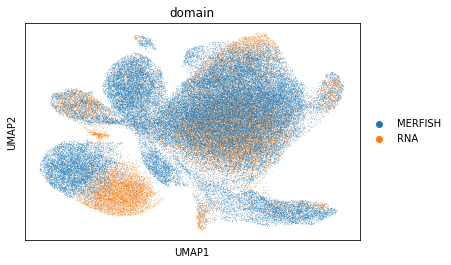

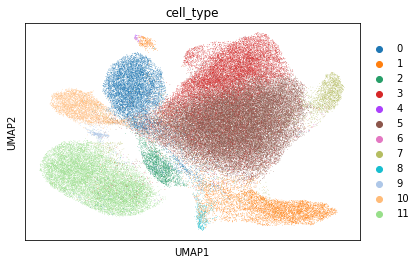

In [16]:
sc.pp.neighbors(adata_z, use_rep="X")
sc.tl.umap(adata_z)
sc.pl.umap(adata_z, color="domain", show=True)
sc.pl.umap(adata_z, color="cell_type", show=True)

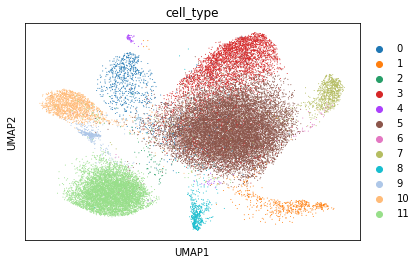

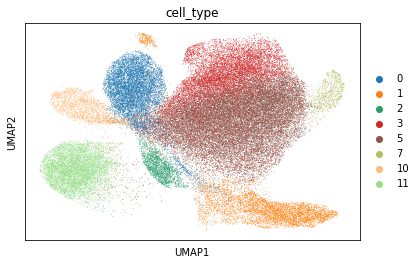

In [17]:
sc.pl.umap(adata_z[adata_z.obs["domain"]=="RNA"], color="cell_type", show=True)
sc.pl.umap(adata_z[adata_z.obs["domain"]=="MERFISH"], color="cell_type", show=True)

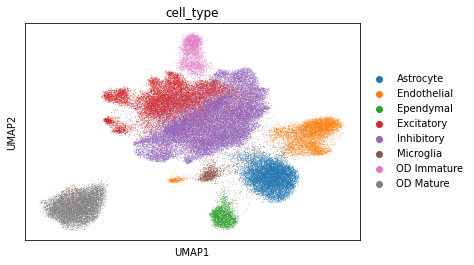

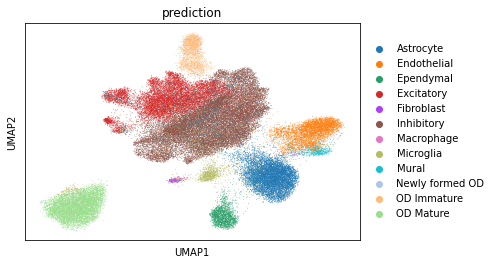

In [18]:
sc.pp.neighbors(adata_zt, use_rep="X")
sc.tl.umap(adata_zt)
sc.pl.umap(adata_zt, color="cell_type", show=True)
sc.pl.umap(adata_zt, color="prediction", show=True)

In [19]:
h5adpath = '/data/msyuan/Cross-omics-Annotator/Ablation_study_alignment_emb/save_h5ad/'
adata_z.write(h5adpath+'merfish_spann_adata_z.h5ad')
adata_zt.write(h5adpath+'merfish_spann_adata_zt.h5ad')

[]

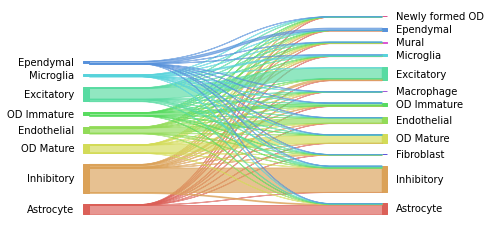

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from pysankey import sankey

sankey_df = pd.DataFrame({"cell_type":truth_ct, "predictions":pred_ct})
sky = sankey(left=sankey_df["cell_type"], right=sankey_df["predictions"], aspect=30, fontsize=10)
sky.plot()

In [21]:
savepath = '/data/msyuan/Cross-omics-Annotator/Ablation study(alignment)/model_save/'
torch.save(encoder.state_dict(), savepath+'spann_encoder.pt')
torch.save(decoder.state_dict(), savepath+'spann_decoder.pt')
torch.save(classifier.state_dict(), savepath+'spann_classifier.pt')